In [1]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import DataLoader, Dataset
from albumentations.pytorch.transforms import ToTensorV2
import albumentations
import torch
import os, cv2
import numpy as np
import random

dataset_dir = '../dataset'
train_coco = COCO(os.path.join(dataset_dir, 'train.json'))
test_coco = COCO(os.path.join(dataset_dir, 'test.json'))

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [2]:
class CustomDataset(Dataset):
    '''
      data_dir: data가 존재하는 폴더 경로
      transforms: data transform (resize, crop, Totensor, etc,,,)
    '''

    def __init__(self, annotation, data_dir, transforms=None, mosaic=False):
        super().__init__()
        self.data_dir = data_dir
        self.coco = COCO(annotation)
        self.predictions = {
            "images": self.coco.dataset["images"].copy(),
            "categories": self.coco.dataset["categories"].copy(),
            "annotations": None
        }
        self.transforms = transforms
        self.mosaic = mosaic

    def __getitem__(self, index: int):
        if self.mosaic and random.random() <= 1:
            self.transforms = None
            return self.load_mosaic(index)
        else:
            return self.load_image_target(index)

    def load_image_target(self, index):
        image_id = self.coco.getImgIds(imgIds=index)

        image_info = self.coco.loadImgs(image_id)[0]

        image = cv2.imread(os.path.join(self.data_dir, image_info['file_name']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        ann_ids = self.coco.getAnnIds(imgIds=image_info['id'])
        anns = self.coco.loadAnns(ann_ids)

        boxes = np.array([x['bbox'] for x in anns])

        # boxes (x_min, y_min, x_max, y_max)
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

        # torchvision faster_rcnn은 label=0을 background로 취급
        # torchvision 사용하는 경우 class_id를 1~10으로 수정 필요
        labels = np.array([x['category_id'] for x in anns])
        labels = torch.as_tensor(labels, dtype=torch.int64)

        label_names = [self.coco.loadCats(x['category_id'])[0]['name'] for x in anns]
        # areas = np.array([x['area'] for x in anns])
        # areas = torch.as_tensor(areas, dtype=torch.float32)

        # is_crowds = np.array([x['iscrowd'] for x in anns])
        # is_crowds = torch.as_tensor(is_crowds, dtype=torch.int64)
        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([index]),
                  'label_names': label_names}

        # transform
        if self.transforms :
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            target['boxes'] = torch.tensor(sample['bboxes'], dtype=torch.float32)
        return image, target, image_id

    def load_mosaic(self, index):
        # Mosaic에서 사용할 4장의 이미지를 선택
        indices = [index] + [random.randint(0, len(self.coco.getImgIds())+1) for _ in range(3)]
        images = []
        final_boxes = []
        labels = []

        s = 1024  # 기본 크기 (전체 Mosaic 이미지 크기)
        mosaic_img = np.zeros((s, s, 3), dtype=np.float32)
        xc, yc = np.random.randint(s * 0.25, s * 0.75, (2,))

        # Load images
        for i, idx in enumerate(indices):
            image, target, _ = self.load_image_target(idx)
            h, w = image.shape[:2]

            if not isinstance(image, np.ndarray):
                image = image.cpu().numpy().transpose(1,2,0)

            # 각각의 이미지를 중앙 기준으로 배치
            if i == 0:  # top-left
                x1a, y1a, x2a, y2a = 0, 0, xc, yc
                x1b, y1b, x2b, y2b = s - xc, s - yc, s, s
            elif i == 1:  # top-right
                x1a, y1a, x2a, y2a = xc, 0, s, yc
                x1b, y1b, x2b, y2b = 0, s - yc, s - xc, s
            elif i == 2:  # bottom-left
                x1a, y1a, x2a, y2a = 0, yc, xc, s
                x1b, y1b, x2b, y2b = s - xc, 0, s, s-yc
            elif i == 3:  # bottom-right
                x1a, y1a, x2a, y2a = xc, yc, s, s
                x1b, y1b, x2b, y2b = 0, 0, s-xc, s-yc

            offset_x = x1a - x1b
            offset_y = y1a - y1b

            boxes = target['boxes']
            boxes[:, 0] += offset_x
            boxes[:, 1] += offset_y
            boxes[:, 2] += offset_x
            boxes[:, 3] += offset_y

            # 이미지 배치
            mosaic_img[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            final_boxes.append(boxes)
            labels.append(target['labels'])

        # 합친 이미지 생성
        final_boxes = np.vstack(final_boxes)
        final_boxes[:, 0:] = np.clip(final_boxes[:, 0:], 0, s).astype(np.int32)

        final_labels = np.concatenate(labels, axis=0)
        label_names = [self.coco.loadCats(x)[0]['name'] for x in final_labels.tolist()]

        # (xmin = 0 & xmax =0) | (ymin = 0 & ymax=0) 제외
        delete_list = []
        for i in range(len(final_boxes)):
            if final_boxes[i][0] == final_boxes[i][2] or final_boxes[i][1] == final_boxes[i][3]:
                delete_list.append(i)

        final_boxes = np.delete(final_boxes, delete_list, axis=0)
        final_labels = np.delete(final_labels, delete_list, axis=0)
        label_names = np.delete(label_names, delete_list, axis=0)

        target = {'boxes': final_boxes, 'labels': final_labels, 'image_id': torch.tensor([index]),
                   'label_names': label_names}

        return mosaic_img, target, index

    def __len__(self) -> int:
        return len(self.coco.getImgIds())


In [10]:
def get_train_transform():
    return albumentations.Compose([
        albumentations.RandomSizedBBoxSafeCrop(height=300, width=300, p=1),
        albumentations.Resize(1024, 1024),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return albumentations.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [11]:
ds = CustomDataset(os.path.join(dataset_dir, 'train.json'), dataset_dir, transforms=get_train_transform(), mosaic=False)


loading annotations into memory...
Done (t=0.22s)
creating index...
index created!


In [13]:
img.shape

(1024, 1024, 3)

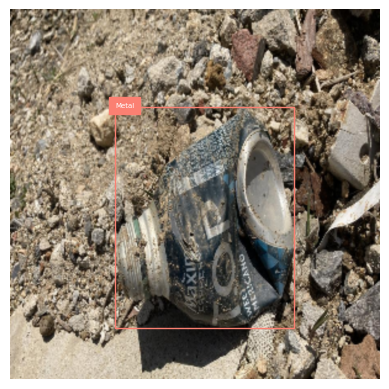

In [12]:
image, target, image_index = ds[100]
img = image.permute(1,2,0).detach().cpu().numpy()
fig, ax = plt.subplots(1)

colors = {}
for i, label in enumerate(target['labels']):
    category_name = target['label_names'][i]

    if category_name not in colors:
        colors[category_name] = plt.get_cmap('Set3')(label)

    x_min, y_min, x_max, y_max = target['boxes'][i]

    edgecolor = colors[category_name]
    rect = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, linewidth=1, edgecolor=edgecolor, facecolor='none')
    ax.add_patch(rect)
    ax.text(x_min, y_min, category_name, color='white', fontsize=5, backgroundcolor=edgecolor)

plt.axis('off')
ax.imshow(img)

In [3]:
img_id   = train_coco.getImgIds(imgIds=5)  # 여기 id만 수정해서 사용
img_info = train_coco.loadImgs(img_id)[0]
ann_id   = train_coco.getAnnIds(imgIds=img_id)
anns     = train_coco.loadAnns(ann_id)

In [8]:
image_ids = train_coco.getImgIds()

Ws = []
Hs = []

# 모든 이미지에 대해 반복
for img_id in image_ids:
    # 해당 이미지에 있는 annotation 가져오기
    ann_ids = train_coco.getAnnIds(imgIds=img_id)
    anns = train_coco.loadAnns(ann_ids)
    
    # 각 annotation의 bbox에서 h, w 추출
    for ann in anns:
        x, y, w, h = ann['bbox']  # bbox: [x_min, y_min, width, height]
        Ws.append(w)
        Hs.append(h)

Ws.sort()
Hs.sort()
Wp90 = int(len(Ws)*0.9)-1
Hp90 = int(len(Hs)*0.9)-1
print(Ws[Wp90])
print(Ws[Hp90])

547.6
547.6


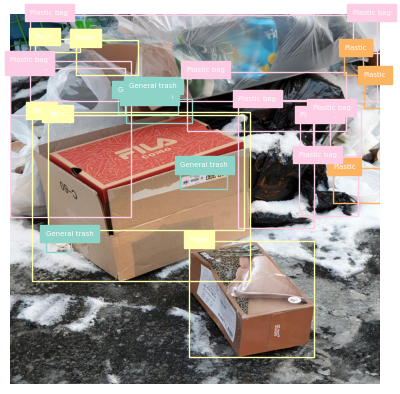

In [ ]:
img_id   = train_coco.getImgIds(imgIds=5)  # 여기 id만 수정해서 사용
img_info = train_coco.loadImgs(img_id)[0]
ann_id   = train_coco.getAnnIds(imgIds=img_id)
anns     = train_coco.loadAnns(ann_id)

img = cv2.imread(os.path.join(dataset_dir, img_info['file_name']))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(float)
img /= 255.0

fig, ax = plt.subplots(1)

colors = {}
for ann in anns:
    category_id   = ann['category_id']
    category_name = train_coco.loadCats(category_id)[0]['name']

    if category_name not in colors:
        colors[category_name] = plt.get_cmap('Set3')(category_id)

    x, y, w, h = ann['bbox']

    edgecolor = colors[category_name]
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor=edgecolor, facecolor='none')
    ax.add_patch(rect)
    ax.text(x, y, category_name, color='white', fontsize=5, backgroundcolor=edgecolor)

plt.axis('off')
ax.imshow(img)

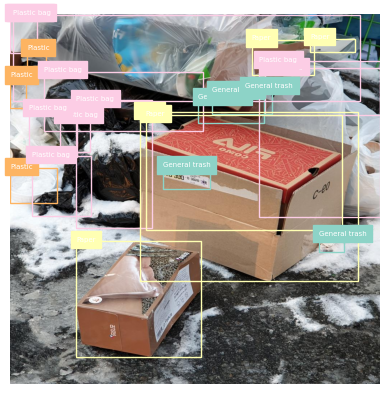

In [ ]:
import albumentations

transform = albumentations.Compose(
    [
        albumentations.HorizontalFlip(p=1)
    ],
    bbox_params=albumentations.BboxParams(format='coco')
)

img_id   = train_coco.getImgIds(imgIds=5)  # 여기 id만 수정해서 사용
img_info = train_coco.loadImgs(img_id)[0]
ann_id   = train_coco.getAnnIds(imgIds=img_id)
anns     = train_coco.loadAnns(ann_id)

img = cv2.imread(os.path.join(dataset_dir, img_info['file_name']))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(float)
img /= 255.0

def visualize_bbox(ax, x, y, w, h, category_name, colors):
    edgecolor = colors[category_name]
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor=edgecolor, facecolor='none')
    ax.add_patch(rect)
    ax.text(x, y, category_name, color='white', fontsize=5, backgroundcolor=edgecolor)
    return ax

fig, ax = plt.subplots(1)
is_train = True
bboxes = []
colors = {}
for ann in anns:
    x, y, w, h    = ann['bbox']
    category_id   = ann['category_id']
    category_name = train_coco.loadCats(category_id)[0]['name']

    if is_train == True:
        bboxes.append([x, y, w, h, category_name])

    if category_name not in colors:
        colors[category_name] = plt.get_cmap('Set3')(category_id)

transform1 = transform(image=img, bboxes=bboxes)
transform1_image = transform1['image']
transform1_bboxes = transform1['bboxes']

for bbox in transform1_bboxes:
    x, y, w, h    = bbox[0], bbox[1], bbox[2], bbox[3]
    category_name = bbox[4]
    ax = visualize_bbox(ax, x, y,w, h, category_name, colors)

plt.axis('off')
ax.imshow(transform1_image)

In [ ]:
# TO DO 1 : 여러 개 파이프라인 구축
# TO DO 2 : 여러 개의 이미지에 대해서 동작하게끔 작성
# TO DO 3 : MOSAIC 구현
# TO DO 4 : 리팩토링으로 정리